In [1]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git

Cloning into 'Facial-Similarity-with-Siamese-Networks-in-Pytorch'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 550 (delta 6), reused 18 (delta 6), pack-reused 532
Receiving objects: 100% (550/550), 6.32 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
cd /content/Facial-Similarity-with-Siamese-Networks-in-Pytorch

/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch


### Import

In [3]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

- Helper functions
###Set of helper functions

In [21]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Configuration Class
- A simple class to manage configuration

In [22]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

### Custom Dataset Class
- This dataset generates a pair of images. 0 for geniune pair
  and 1 for imposter pair

In [23]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
      ## Initialize dataset properties
        self.imageFolderDataset = imageFolderDataset ## Dataset with image paths and labels
        self.transform = transform #Transformation to apply to images (e.g., resizing, normalization)
        self.should_invert = should_invert # Whether to invert the colors of the images

    def __getitem__(self,index):
      ## Get an image pair for training/testing the Siamese network
        img0_tuple = random.choice(self.imageFolderDataset.imgs)## Randomly select the first image
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) ## # Randomly decide if the second image should be from the same class

        if should_get_same_class:
          # # Select a second image from the same class
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break # Stop if the selected image is from the same class
        else:
          # Select a second image from a different class
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break # Stop if the selected image is from a different class

        img0 = Image.open(img0_tuple[0]) # Open the first image
        img1 = Image.open(img1_tuple[0]) # Open the second image
        img0 = img0.convert("L") # Convert the first image to grayscale
        img1 = img1.convert("L") # Convert the second image to grayscale

        if self.should_invert:
          # Optionally invert the image colors
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
          # Apply transformations if any
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
# Return the pair of images and a label indicating if they are from the same class or not
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
# Return the total number of images in the dataset
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

### Using Image Folder Dataset

In [24]:
# Create an ImageFolder dataset from the specified directory
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [25]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

### Visualising some of the data
- The top row and the bottom row of any column is one pair.  
- The 0s and 1s correspond to the column of the image. 1
 indiciates dissimilar, and 0 indicates similar.

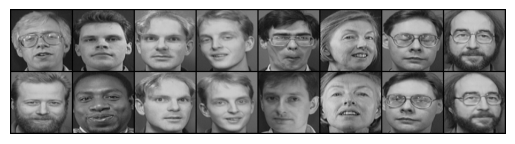

[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [26]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


### Neural Net Definition
We will use a standard convolutional neural network

In [27]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

### Contrastive Loss

In [29]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### Training Time!

In [30]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)



In [31]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [32]:
counter = []
loss_history = []
iteration_number= 0

Epoch number 0
 Current loss 1.7614696025848389

Epoch number 1
 Current loss 3.9825377464294434

Epoch number 2
 Current loss 1.5231587886810303

Epoch number 3
 Current loss 0.9553463459014893

Epoch number 4
 Current loss 1.0205411911010742

Epoch number 5
 Current loss 0.4596051573753357

Epoch number 6
 Current loss 0.3889036476612091

Epoch number 7
 Current loss 0.4142536520957947

Epoch number 8
 Current loss 0.25282663106918335

Epoch number 9
 Current loss 0.4068593680858612

Epoch number 10
 Current loss 0.2564317584037781

Epoch number 11
 Current loss 0.16871857643127441

Epoch number 12
 Current loss 0.13274002075195312

Epoch number 13
 Current loss 0.10720664262771606

Epoch number 14
 Current loss 0.1164078563451767

Epoch number 15
 Current loss 0.17760799825191498

Epoch number 16
 Current loss 0.18886221945285797

Epoch number 17
 Current loss 0.12992537021636963

Epoch number 18
 Current loss 0.13813214004039764

Epoch number 19
 Current loss 0.05568249523639679

E

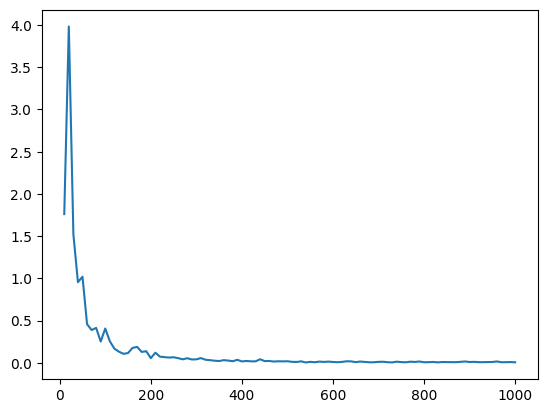

In [33]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

### Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


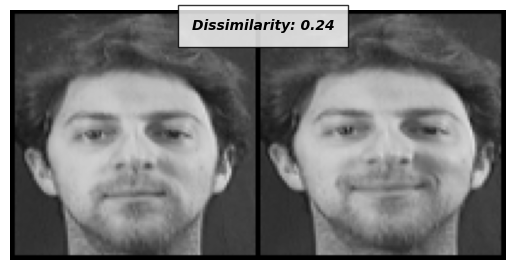

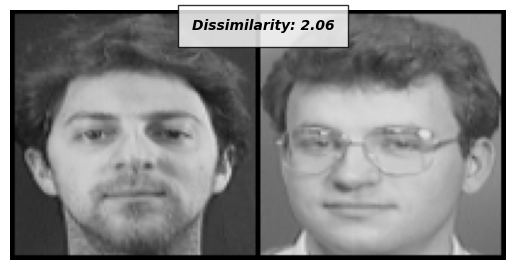

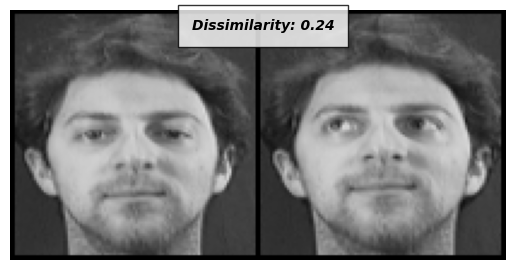

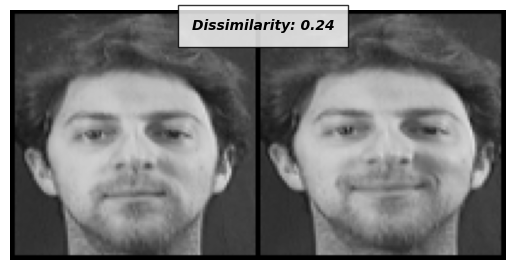

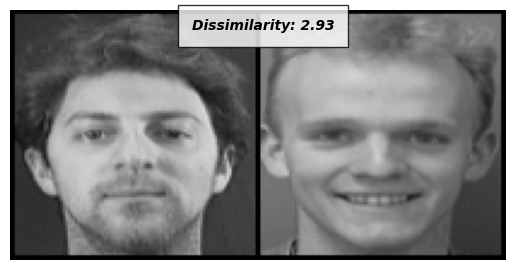

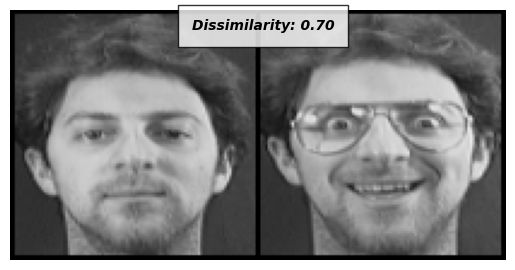

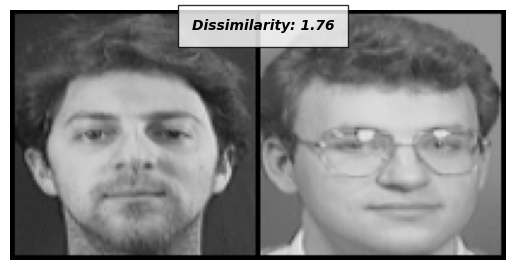

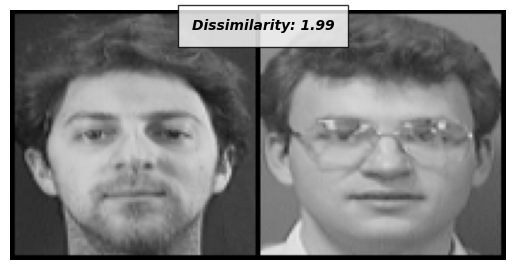

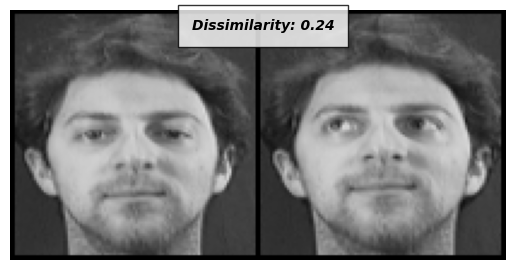

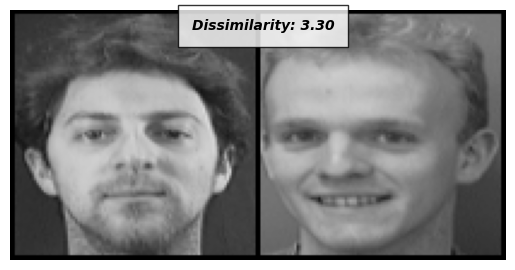

In [34]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))